In [99]:
# Import some useful packages
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider

import tensorflow as tf
import tensorflow.keras.backend as K

In [102]:
# Layers for FNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense

# Optimizers for training
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

# Losses for training
from tensorflow.keras import losses

# For data preprocessing
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

In [103]:
# Load dataset
(x_train, y_train0), (x_test, y_test0) = datasets.mnist.load_data()

In [104]:
# Reshape sizeL:將 x 改成784維度
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

# Normalize the range of featurs
x_train = x_train / x_train.max()
x_test = x_test / x_test.max()

# One-hot encoding:將y轉換成類別資料
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

In [105]:
x_train.shape

(60000, 784)

In [106]:
enc_1 = Dense(512, activation='sigmoid')
enc_2 = Dense(128, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(128, activation='sigmoid')
dec_1 = Dense(512, activation='sigmoid')
dec_0 = Dense(784, activation='sigmoid')


In [107]:
x = Input(shape=(784,))
enc_1_x = enc_1(x)
enc_2_x = enc_2(enc_1_x)


z_mean = enc_mean(enc_2_x)
z_log_var = enc_log_var(enc_2_x)


進行抽樣分配

In [108]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [109]:
# Sampling function wrapped as a Keras layer
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

# Define Decoder part of VAE
z_input = Input(shape=(2,))
x_hat = dec_0(dec_1(dec_2(z_input)))

In [110]:
x_hat = dec_0(dec_1(dec_2(z)))

VAE = Model(x, x_hat)
VAE.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_46 (Dense)                (None, 512)          401920      input_15[0][0]                   
__________________________________________________________________________________________________
dense_47 (Dense)                (None, 128)          65664       dense_46[0][0]                   
__________________________________________________________________________________________________
dense_48 (Dense)                (None, 2)            258         dense_47[0][0]                   
____________________________________________________________________________________________

In [111]:
# reconstruction_loss = tf.keras.losses.mse(inputs, outputs)
reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

In [112]:
VAE.compile(optimizer=Adam())

訓練VAE

In [113]:
VAE.fit(x_train, batch_size=100, epochs=6)

Train on 60000 samples
Epoch 1/6
60000/60000 [==============================] - 20s 331us/sample - loss: 53.8614
Epoch 2/6
60000/60000 [==============================] - 12s 203us/sample - loss: 50.0181
Epoch 3/6
60000/60000 [==============================] - 11s 180us/sample - loss: 47.3348
Epoch 4/6
60000/60000 [==============================] - 12s 192us/sample - loss: 43.9999
Epoch 5/6
60000/60000 [==============================] - 11s 183us/sample - loss: 42.1257
Epoch 6/6
60000/60000 [==============================] - 11s 189us/sample - loss: 40.5016


In [114]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_46 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_47 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_48 (Dense)             (None, 2)                 258       
Total params: 467,842
Trainable params: 467,842
Non-trainable params: 0
_________________________________________________________________


Encoder 的視覺化呈現

In [121]:
idx = np.random.randint(x_train.shape[0])
print(f"第 {idx} 圖的 latent 表示為 {VAE_Encoder.predict(x_train[idx: idx+1]).squeeze()}")

第 46538 圖的 latent 表示為 [ 0.89498115 -0.9178451 ]


In [123]:
indices = np.random.randint(x_train.shape[0], size=3000)

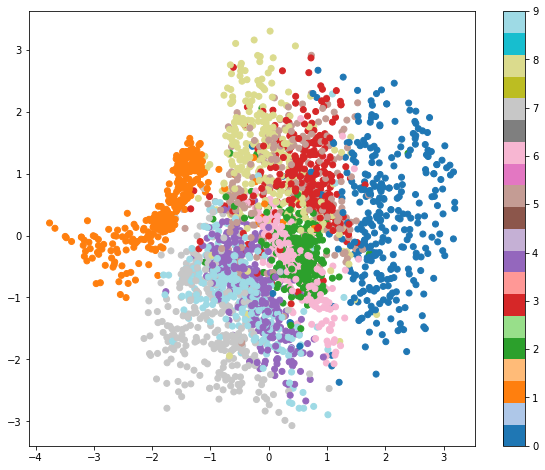

In [124]:
VAE_latents = VAE_Encoder.predict(x_train[indices])
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

In [140]:
#visualze decoder
VAE_Decoder = Model(z_input, dec_0(dec_1(dec_2(z_input))))
VAE_Decoder.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_50 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_51 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_52 (Dense)             (None, 784)               402192    
Total params: 468,624
Trainable params: 468,624
Non-trainable params: 0
_________________________________________________________________


Decoder 的視覺化呈現

In [141]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [142]:
n=20
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

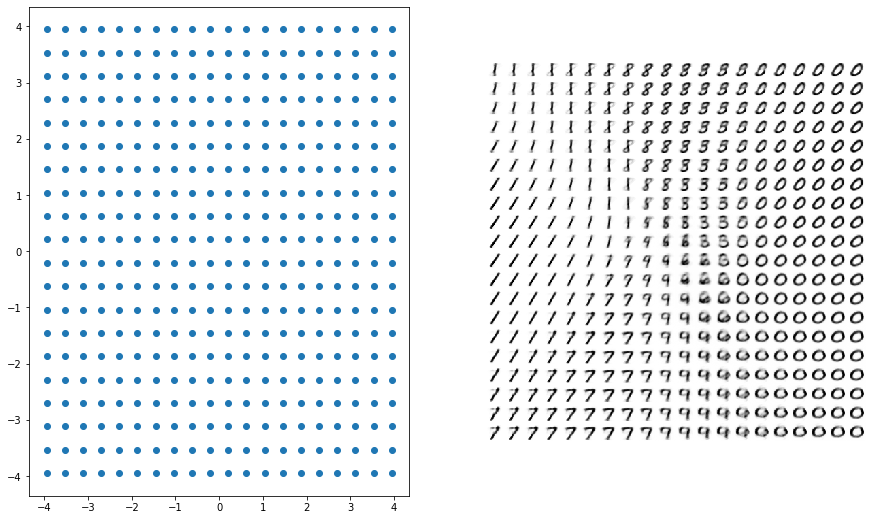

In [144]:
#視覺化-Decoder
plt.figure(figsize=(15, 9))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

動態比較

In [147]:
idx_1, idx_2 = np.random.randint(x_train.shape[0], size=2)

In [148]:
def inBetween(t):
    data_0 = x_train[idx_1].reshape(28, 28)
    data_1 = x_train[idx_2].reshape(28, 28)
    data_t = (1-t)*data_0 + t*data_1
    
    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')
    ax2.set_title('t=0')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')
    ax3.set_title(f't={t}')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')
    ax4.set_title('t=1')



In [149]:
interact(inBetween, t=FloatSlider(value=0, min=0, max=1.0, step=0.02,))

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>